# <span style="color: #6495ED"> Prerequisites </span>

In [320]:
# Import all the necessary libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)

In [230]:
# Load your Spotify API credentials stored in the config file
with open("config.json") as config_file:
    config = json.load(config_file)

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=config["SPOTIPY_CLIENT_ID"],
    client_secret=config["SPOTIPY_CLIENT_SECRET"],
    redirect_uri=config["SPOTIPY_REDIRECT_URI"],
    scope="user-library-read playlist-read-private playlist-read-collaborative"  #  if you need multiple scopes, just pass a space-separated string of all the permissions you need 
))

# <span style="color: #6495ED"> Data Extraction </span>

In [231]:
# Get current user's playlists (saved in the library)
user_playlists = sp.current_user_playlists()

print(type(user_playlists))
print(user_playlists.keys())    # Check the keys, so we know what to address to get the songs data

<class 'dict'>
dict_keys(['href', 'limit', 'next', 'offset', 'previous', 'total', 'items'])


In [ ]:
# Return the names of all the current user's playlists
for playlist in user_playlists['items']:
    print(playlist['name'])

<span style="color:orange"> **IMPORTANT MESSAGE!**

Your Top Songs playlists are created by Spotify, so they are not visible as the current user's playlists in the library.  
I faced some issues accessing them via the Spotify playlists ID extracted from the playlists links, so I decided to manually save the original playlists as new playlists in my library.  
Now I can see them. I also changed their names, so it's easier to access them.</span>

In [232]:
# Save all the TOP playlists in the Spotify user's library to a list
top_playlists = [playlist for playlist in user_playlists['items'] if playlist['name'].startswith('TOP')]   # Here we select only the playlists starting with TOP in their names 

# Print playlist names and IDs
print("All my TOP playlists")
print("-"*40)
for playlist in top_playlists:
    print(f"{playlist['name']} - {playlist['id']}")

All my TOP playlists
----------------------------------------
TOP 2022 - 5ow0VcdYbpKZi0fouz9D9e
TOP 2024 - 1GJNRIRjLT3qIa8smRiqxi
TOP 2023 - 2fCKUatPCbCXFTeYetlvvs
TOP 2021 - 41GXDuh7y4Q4yyZj4brhy3
TOP 2020 - 0qmZlBPV811vhvnrUANJii
TOP 2018 - 0pkUpezEdjR3qqvb8t5Udq
TOP 2017 - 11uLlCiVGMzxtGo694iXnO
TOP 2019 - 3N1qF0ZwB2OOIJVUJk0fE9


In [243]:
# Create an empty list to store data for each track
all_tracks = []

# Extract data for each track from every TOP playlist and store it in the list
for playlist in top_playlists:
    playlist_id = playlist['id']
    playlist_name = playlist['name']
    playlist_tracks = sp.playlist_tracks(playlist_id)
    
    for position, item in enumerate(playlist_tracks['items'], start=1):
        track = item['track']
        all_tracks.append({
            'year': playlist_name.split(' ')[1],  
            'position': position,
            'track_name': track['name'],
            'artist': track['artists'][0]['name'],
            'album': track['album']['name'],
            'release_type': track['album']['album_type'], 
            'duration_ms': track['duration_ms'],
            'track_popularity': track['popularity'],
            'total_tracks': track['album']['total_tracks'],
            'track_number': track['track_number'],
            'release_date': track['album']['release_date'],
            'release_date_precision': track['album']['release_date_precision'],
            'track_id': track['id'],
            'artist_id': track['album']['artists'][0]['id'],
            'album_id': track['album']['id']
        })

# Convert to a DataFrame
df_playlists = pd.DataFrame(all_tracks)
df_playlists.head()

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id
0,2022,1,Older,Alec Benjamin,(Un)Commentary,album,164396,61,13,12,2022-04-15,day,7JSSJf4TcJDv8KL6UO8FGH,5IH6FPUwQTxPSXurCrcIov,5Wvcnn5547f6xz8F9Kz6rO
1,2022,2,Tides,Ed Sheeran,=,album,195760,55,14,1,2021-10-25,day,2JiHR4gCDjXwYVRDmwdk95,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq
2,2022,3,Overpass Graffiti,Ed Sheeran,=,album,236906,66,14,5,2021-10-25,day,4btFHqumCO31GksfuBLLv3,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq
3,2022,4,Bam Bam (feat. Ed Sheeran),Camila Cabello,Familia,album,206070,59,12,4,2022-04-08,day,3lDSWvR0FXWGXo7mhDUs3v,4nDoRrQiYLoBzwC5BhVJzF,5Nn3fX7CuJo7tbibtqASmf
4,2022,5,Light Switch,Charlie Puth,CHARLIE,album,187703,70,12,3,2022-10-06,day,1jEBSDN5vYViJQr78W7jr2,6VuMaDnrHyPL1p4EHjYLi7,5Jk4Eg7pxYhDrWJCVVzmMt


# <span style="color: #6495ED"> Data Cleaning & Transformation </span>

In [244]:
# My TOP playlists are in mixed order, so let's sort them chronologically 
df_playlists.sort_values(['year', 'position'], inplace=True, ignore_index=True)
df_playlists

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id
0,2017,1,Walking The Wire,Imagine Dragons,Evolve,album,232906,1,11,4,2017-06-23,day,6jmngk8Fwup05JZ6kgXEGX,53XhwfbYqKCa1cC15pYq2q,5GlPAy2PRJW06GVFhKwGTl
1,2017,2,Everglow,Coldplay,A Head Full of Dreams,album,282693,68,11,4,2015-12-04,day,5qfZRNjt2TkHEL12r3sDEU,4gzpq5DPGxSnKTe4SA8HAU,3cfAM8b8KqJRoIzt3zLKqw
2,2017,3,Castle on the Hill - Seeb Remix,Ed Sheeran,Castle on the Hill (Seeb Remix),single,230972,34,1,1,2017-05-19,day,2SK04gQYClGFLqNGklgJpN,6eUKZXaKkcviH0Ku9w2n3V,6LhLsGjkUVzAuywuuFIkdu
3,2017,4,The Bird's Song,MaJLo,Over The Woods,album,247225,23,10,7,2017-03-24,day,0a7e7kH7VOlwDgibIq4OpD,5aTUKcNsRYdEPhdEh7bOwL,77v43OEmXslTsE0aYCPZcc
4,2017,5,Shape of You - Galantis Remix,Ed Sheeran,Shape of You (Galantis Remix),single,195988,39,1,1,2017-02-10,day,5H7CwzYZ60e7w69tX4ivQN,6eUKZXaKkcviH0Ku9w2n3V,6K5S3fWJ6logqsusWVaJUG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2024,96,Heaven,Niall Horan,The Show,album,186043,72,10,1,2023-06-09,day,5FQ77Cl1ndljtwwImdtjMy,1Hsdzj7Dlq2I7tHP7501T4,7CwQcswdSnPsSwQtskEmT4
796,2024,97,(Isn’t It) Obvious,Alessia Cara,(Isn’t It) Obvious,single,231496,52,1,1,2024-10-21,day,2WHpyoNdtUirfIv256JznP,2wUjUUtkb5lvLKcGKsKqsR,6mDGrC2zC5bugpOTPwNedv
797,2024,98,Movie Star,Lizzy McAlpine,Older,album,92040,46,14,4,2024-04-05,day,6aRmjhWmg9pAioffjegxtp,1GmsPCcpKgF9OhlNXjOsbS,30fIbIvd1AN04FrBt12KhM
798,2024,99,Colourblind,Ed Sheeran,- (Deluxe),album,209267,52,18,7,2023-05-05,day,290x9rCh2EWcJ9YKpfiI9z,6eUKZXaKkcviH0Ku9w2n3V,2WFFcvzM0CgLaSq4MSkyZk


In [245]:
df_playlists.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    800 non-null    object
 1   position                800 non-null    int64 
 2   track_name              800 non-null    object
 3   artist                  800 non-null    object
 4   album                   800 non-null    object
 5   release_type            800 non-null    object
 6   duration_ms             800 non-null    int64 
 7   track_popularity        800 non-null    int64 
 8   total_tracks            800 non-null    int64 
 9   track_number            800 non-null    int64 
 10  release_date            800 non-null    object
 11  release_date_precision  800 non-null    object
 12  track_id                800 non-null    object
 13  artist_id               800 non-null    object
 14  album_id                800 non-null    object
dtypes: int

In [236]:
df_playlists.nunique()

year                        8
position                  100
track_name                653
artist                    198
album                     395
release_type                3
duration_ms               663
track_popularity           92
total_tracks               31
track_number               23
release_date              343
release_date_precision      2
track_id                  697
artist_id                 196
album_id                  414
dtype: int64

In [237]:
print(df_playlists['year'].value_counts())
print(df_playlists['release_type'].value_counts())
print(df_playlists['release_date_precision'].value_counts())

year
2017    100
2018    100
2019    100
2020    100
2021    100
2022    100
2023    100
2024    100
Name: count, dtype: int64
release_type
album          569
single         226
compilation      5
Name: count, dtype: int64
release_date_precision
day     787
year     13
Name: count, dtype: int64


Based on the above values, let's convert some columns to `category` type to reduce memory usage.

In [246]:
df_playlists = df_playlists.astype({'year': 'category', 'release_type': 'category', 'release_date_precision': 'category'})
df_playlists.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   year                    800 non-null    category
 1   position                800 non-null    int64   
 2   track_name              800 non-null    object  
 3   artist                  800 non-null    object  
 4   album                   800 non-null    object  
 5   release_type            800 non-null    category
 6   duration_ms             800 non-null    int64   
 7   track_popularity        800 non-null    int64   
 8   total_tracks            800 non-null    int64   
 9   track_number            800 non-null    int64   
 10  release_date            800 non-null    object  
 11  release_date_precision  800 non-null    category
 12  track_id                800 non-null    object  
 13  artist_id               800 non-null    object  
 14  album_id                80

In [247]:
df_playlists.describe(include='all')

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id
count,800,800.000000,800,800,800,800,800.000000,800.000000,800.000000,800.000000,800,800,800,800,800
unique,8,NaN,653,198,395,3,NaN,NaN,NaN,NaN,343,2,697,196,414
top,2017,NaN,Castle on the Hill,Ed Sheeran,- (Deluxe),album,NaN,NaN,NaN,NaN,2023-05-05,day,6PCUP3dWmTjcTtXY02oFdT,6eUKZXaKkcviH0Ku9w2n3V,2WFFcvzM0CgLaSq4MSkyZk
freq,100,NaN,6,140,29,569,NaN,NaN,NaN,NaN,29,787,6,139,29
mean,NaN,50.500000,NaN,NaN,NaN,NaN,211578.842500,45.778750,10.933750,5.328750,NaN,NaN,NaN,NaN,NaN
std,NaN,28.884128,NaN,NaN,NaN,NaN,44945.619557,24.616199,6.813581,4.748037,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,25.750000,NaN,NaN,NaN,NaN,185636.250000,33.000000,4.000000,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,50.500000,NaN,NaN,NaN,NaN,208500.000000,50.000000,12.000000,4.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,75.250000,NaN,NaN,NaN,NaN,231155.000000,63.000000,15.000000,8.000000,NaN,NaN,NaN,NaN,NaN


Sometimes songs just come and go, and they are no longer available on Spotify. There is a trace of them, but no data left.  
There are two such tracks in my playlists, so let's get rid of them. 

In [248]:
df_playlists.isna().sum()

year                      0
position                  0
track_name                0
artist                    0
album                     0
release_type              0
duration_ms               0
track_popularity          0
total_tracks              0
track_number              0
release_date              0
release_date_precision    0
track_id                  0
artist_id                 0
album_id                  0
dtype: int64

In [249]:
# Unfortunately, they are not saved as NaN values, but empty strings
df_playlists[df_playlists['track_name'] =='']

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id
172,2018,73,,,,single,0,0,1,1,0000,year,4aN7eVpleDPkp3C1oDFd4x,0LyfQWJT6nXafLPZqxe9Of,5FqITpi8rcmOgJ1pR9YuSs
190,2018,91,,,,single,0,0,2,2,0000,year,3Qsv4VR1YDlLe2T597LNaJ,0LyfQWJT6nXafLPZqxe9Of,6txt6BEwqboOhGfyZk5XkY


In [250]:
# Remove these empty tracks
tracks_to_drop = df_playlists[df_playlists['track_name']==''].index
df_playlists.drop(labels=tracks_to_drop, inplace=True) 
df_playlists[df_playlists['track_name'] =='']   # Sanity check     

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id


## <span style="color: orange"> TU TRZEBA ELEGANCKO ZARZĄDZIĆ DUPLIKATAMI PIOSENEK Z RÓŻNYCH WYDAŃ (singiel/album/album special edition) </span>

- np. Equals & Equals (Tour Edition) - ZOBACZ, ŻE SĄ ZDUPLIKOWANE PIOSENKI

In [ ]:
df_playlists[df_playlists['album'].isin(['= (Tour Edition)', '='])]

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id,release_year,release_month,release_day,same_year
431,2021,32,Tides,Ed Sheeran,=,album,195760,55,14,1,2021-10-25,day,2JiHR4gCDjXwYVRDmwdk95,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,True
450,2021,51,Be Right Now,Ed Sheeran,=,album,211080,49,14,14,2021-10-25,day,3BiiSLo0wyHAY7lpCEO6ge,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,True
474,2021,75,Leave Your Life,Ed Sheeran,=,album,223866,51,14,7,2021-10-25,day,0YbI9lWxUBsCJLb6EBydkr,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,True
486,2021,87,First Times,Ed Sheeran,=,album,185853,59,14,3,2021-10-25,day,5QYnNhTKsN3kE7OaqILA1U,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,True
501,2022,2,Tides,Ed Sheeran,=,album,195760,55,14,1,2021-10-25,day,2JiHR4gCDjXwYVRDmwdk95,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,False
502,2022,3,Overpass Graffiti,Ed Sheeran,=,album,236906,66,14,5,2021-10-25,day,4btFHqumCO31GksfuBLLv3,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,False
507,2022,8,Shivers,Ed Sheeran,=,album,207853,83,14,2,2021-10-25,day,50nfwKoDiSYg8zOCREWAm5,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,False
511,2022,12,I Will Remember You,Ed Sheeran,= (Tour Edition),album,214493,35,23,18,2022-05-27,day,4yVsZALRYQ2cBJCViCTTp0,6eUKZXaKkcviH0Ku9w2n3V,2CIOGAByaHyjQ1EO55JSzC,2022,5,27,True
519,2022,20,Collide,Ed Sheeran,= (Tour Edition),album,210213,25,23,8,2022-05-27,day,362gtoLRmu1RfqolIFxXcL,6eUKZXaKkcviH0Ku9w2n3V,2CIOGAByaHyjQ1EO55JSzC,2022,5,27,True
523,2022,24,Leave Your Life,Ed Sheeran,=,album,223866,51,14,7,2021-10-25,day,0YbI9lWxUBsCJLb6EBydkr,6eUKZXaKkcviH0Ku9w2n3V,32iAEBstCjauDhyKpGjTuq,2021,10,25,False


Let's extract the release year, month, and day from the *release_date* column.

In [251]:
df_playlists['release_year'] = pd.to_datetime(df_playlists['release_date'], format='mixed').dt.year
df_playlists['release_month'] = pd.to_datetime(df_playlists['release_date'], format='mixed').dt.month
df_playlists['release_day'] = pd.to_datetime(df_playlists['release_date'], format='mixed').dt.day
df_playlists.head()

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id,release_year,release_month,release_day
0,2017,1,Walking The Wire,Imagine Dragons,Evolve,album,232906,1,11,4,2017-06-23,day,6jmngk8Fwup05JZ6kgXEGX,53XhwfbYqKCa1cC15pYq2q,5GlPAy2PRJW06GVFhKwGTl,2017,6,23
1,2017,2,Everglow,Coldplay,A Head Full of Dreams,album,282693,68,11,4,2015-12-04,day,5qfZRNjt2TkHEL12r3sDEU,4gzpq5DPGxSnKTe4SA8HAU,3cfAM8b8KqJRoIzt3zLKqw,2015,12,4
2,2017,3,Castle on the Hill - Seeb Remix,Ed Sheeran,Castle on the Hill (Seeb Remix),single,230972,34,1,1,2017-05-19,day,2SK04gQYClGFLqNGklgJpN,6eUKZXaKkcviH0Ku9w2n3V,6LhLsGjkUVzAuywuuFIkdu,2017,5,19
3,2017,4,The Bird's Song,MaJLo,Over The Woods,album,247225,23,10,7,2017-03-24,day,0a7e7kH7VOlwDgibIq4OpD,5aTUKcNsRYdEPhdEh7bOwL,77v43OEmXslTsE0aYCPZcc,2017,3,24
4,2017,5,Shape of You - Galantis Remix,Ed Sheeran,Shape of You (Galantis Remix),single,195988,39,1,1,2017-02-10,day,5H7CwzYZ60e7w69tX4ivQN,6eUKZXaKkcviH0Ku9w2n3V,6K5S3fWJ6logqsusWVaJUG,2017,2,10


# <span style="color: #6495ED"> Data Exploration & Visualization </span>

In [423]:
# Set seaborn styles
sns.set_style('darkgrid')
sns.set_context('notebook')

# Save a selected palette of colors to a list to have it close at hand 
colors = sns.color_palette('mako') 

## <span style="color: #6495ED"> Q1. How many artists appeared in my TOP playlists? </span>

In [252]:
unique_artists_per_year = df_playlists.groupby('year')['artist'].nunique().to_frame('unique_artists')
unique_artists_per_year

C:\Users\michg\AppData\Local\Temp\ipykernel_16684\2189185725.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_artists_per_year = df_playlists.groupby('year')['artist'].nunique().to_frame('unique_artists')


,unique_artists
year,
2017,73
2018,53
2019,30
2020,25
2021,35
2022,38
2023,36
2024,25


Text(0.5, 1.0, 'Number of Unique Artists per Year')

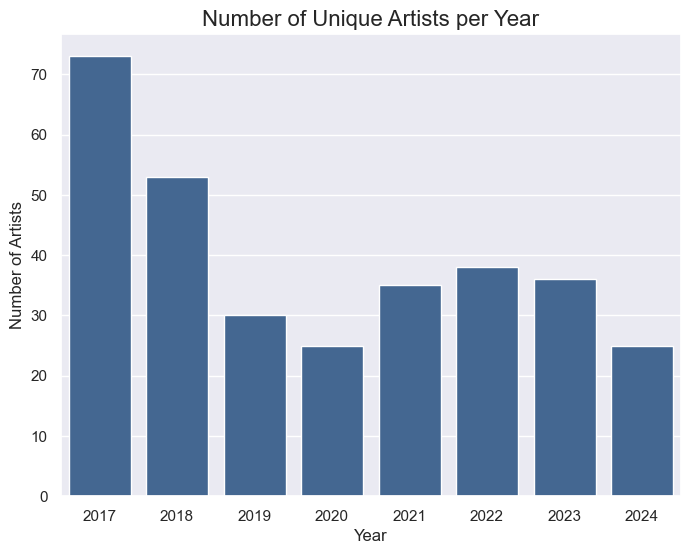

In [434]:
plt.figure(figsize=(8, 6))
           
sns.barplot(data=unique_artists_per_year, x='year', y='unique_artists', color=colors[2])

plt.xlabel('Year')
plt.ylabel('Number of Artists')
plt.title('Number of Unique Artists per Year', fontdict={'size': 16})

## <span style="color: #6495ED"> Q2. Which artists dominated my TOP playlists over the years? </span>

Text(0, -1.5, "Note: 'total' includes all song appearances (songs may appear in multiple playlists), while 'unique' counts distinct songs (no duplicates)")

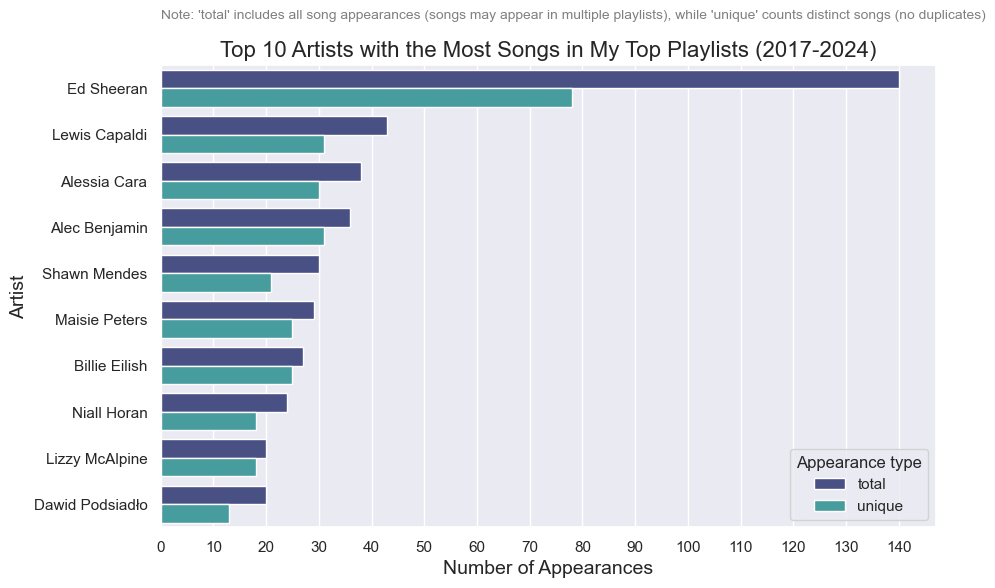

In [453]:
top10_artists_total = df_playlists['artist'].value_counts().head(10).reset_index(name='total')
top10_artists_unique = df_playlists.groupby('artist')['track_name'].nunique().nlargest(10).reset_index(name='unique')

# Merge the two metrics and melt for plotting
top10_artists = top10_artists_total.merge(top10_artists_unique, on='artist', how='left')
top10_artists_melted = top10_artists.melt(id_vars='artist', value_vars=['total', 'unique'], var_name='apperances_type', value_name='n_appearances')

plt.figure(figsize=(10, 6))
sns.barplot(data=top10_artists_melted, x='n_appearances', y='artist', hue='apperances_type', orient='h', palette='mako')

plt.xlabel('Number of Appearances', size=14)
plt.ylabel('Artist', size=14)
plt.title('Top 10 Artists with the Most Songs in My Top Playlists (2017-2024)', size=16)
plt.legend(title='Appearance type')

plt.xticks(np.arange(0, top10_artists_melted['n_appearances'].max()+10, 10))

# Add a note to the plot
plt.text(
    x=0, y=-1.5,  # Set the position
    s="Note: 'total' includes all song appearances (songs may appear in multiple playlists), while 'unique' counts distinct songs (no duplicates)",
    fontsize=10, color='gray', ha='left')

Let's find out how these TOP artists across the years ....

## <span style="color: #6495ED"> Q3. Towarzystwo moich top 5 artystów na przestrzeni lat  </span>
   - fajnym smaczkiem byłoby dodanie do takiego wykresu jakichś wskaźników, kiedy poszczególny artysta wydawał album (bo to fajnie zarysowuje kontekst + komplikuje trochę wykres, więc większy skill)

C:\Users\michg\AppData\Local\Temp\ipykernel_16684\2238772413.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  artist_year = df_playlists.pivot_table(index='artist', columns='year', values='track_name', aggfunc='count', fill_value=0)


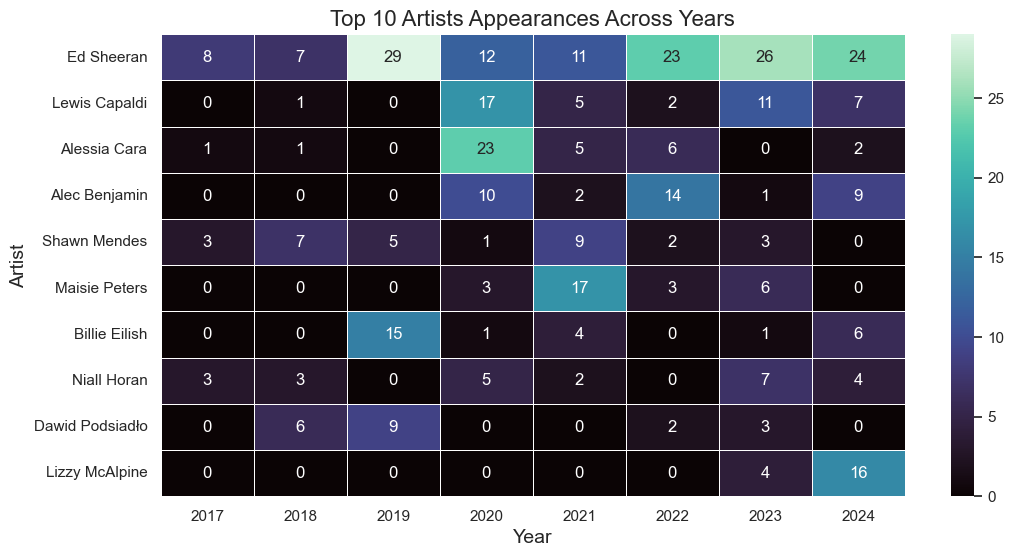

In [ ]:
# Pivot table for artist appearances by year
artist_year = df_playlists.pivot_table(index='artist', columns='year', values='track_name', aggfunc='count', fill_value=0)

# Filter for top 10 artists
top_artists = artist_year.sum(axis=1).nlargest(10).index
artist_year = artist_year.loc[top_artists]

plt.figure(figsize=(12, 6))
sns.heatmap(artist_year, cmap='mako', annot=True, linewidths=0.5)

plt.xlabel('Year', size=14)
plt.ylabel('Artist', size=14)
plt.title('Top 10 Artists Appearances Across Years', size=16)
plt.show()

C:\Users\michg\AppData\Local\Temp\ipykernel_16684\3753320388.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  artist_year = df_playlists.pivot_table(index='artist', columns='year', values='track_name', aggfunc='count', fill_value=0)


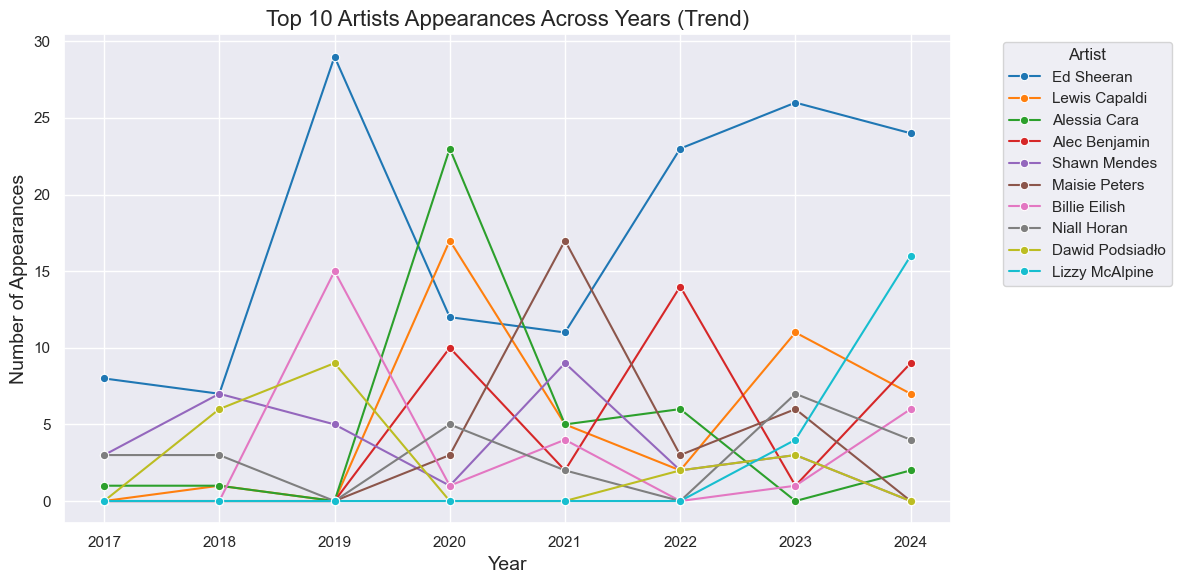

In [576]:
# Pivot table for artist appearances by year
artist_year = df_playlists.pivot_table(index='artist', columns='year', values='track_name', aggfunc='count', fill_value=0)

# Filter for top 10 artists
top_artists = artist_year.sum(axis=1).nlargest(10).index
artist_year = artist_year.loc[top_artists]

# Reset index to prepare for plotting
artist_year = artist_year.reset_index().melt(id_vars='artist', var_name='year', value_name='appearances')

# Plot the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=artist_year, x='year', y='appearances', hue='artist', marker='o', palette='tab10')

# Customize the plot
plt.xlabel('Year', size=14)
plt.ylabel('Number of Appearances', size=14)
plt.title('Top 10 Artists Appearances Across Years (Trend)', size=16)
plt.legend(title='Artist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As we have already discovered above, there are songs that appeared multiple times. Let's find out what the most frequent songs are. 

## <span style="color: #6495ED"> Q4. Which songs dominated over the years? </span>

Text(0, -1.5, 'Note: There were also 12 other songs with 3 appearances')

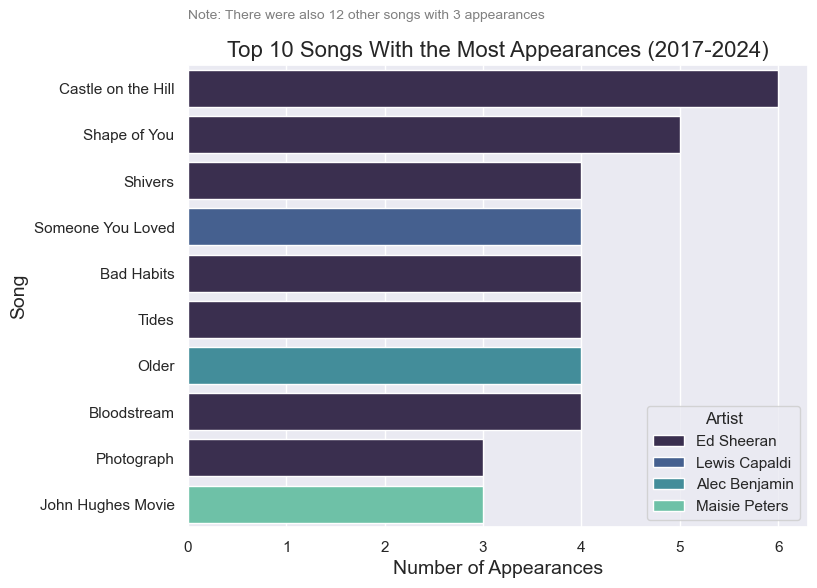

In [255]:
n = 10
top10_songs = df_playlists[['track_name', 'artist']].value_counts().nlargest(n).reset_index()      # Set keep='all' within nlargest() to allow duplicated values (resulting size > n)

# Count the number of duplicated apperance values (we'll use it to add a little note on the plot)
n_duplicated = df_playlists[['track_name', 'artist']].value_counts().nlargest(n, keep='all').count() - df_playlists[['track_name', 'artist']].value_counts().nlargest(n).count()     

plt.figure(figsize=(8, 6))
sns.barplot(data=top10_songs, x='count', y='track_name', hue='artist', orient='h', palette='mako', width=0.8)

plt.title(f'Top {n} Songs With the Most Appearances (2017-2024)', size=16)
plt.xlabel('Number of Appearances', size=14)
plt.ylabel('Song', size=14)
plt.legend(title='Artist')

# Add a note about the songs with duplicated appearance values that didn't fit on the plot
plt.text(
    x=0, y=-1.5,  
    s=f"Note: There were also {n_duplicated} other songs with {top10_songs['count'].min()} appearances",
    fontsize=10, color='gray', ha='left')

## <span style="color: #6495ED"> Q5. What is the ratio of songs released in the playlist year to songs from other years? </span>

In [474]:
# Create a boolean column indicating whether the song was released in the playlist year
df_playlists['same_year'] = df_playlists['year'].astype('int') == df_playlists['release_year']
df_playlists.head()

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id,release_year,release_month,release_day,same_year
0,2017,1,Walking The Wire,Imagine Dragons,Evolve,album,232906,1,11,4,2017-06-23,day,6jmngk8Fwup05JZ6kgXEGX,53XhwfbYqKCa1cC15pYq2q,5GlPAy2PRJW06GVFhKwGTl,2017,6,23,True
1,2017,2,Everglow,Coldplay,A Head Full of Dreams,album,282693,68,11,4,2015-12-04,day,5qfZRNjt2TkHEL12r3sDEU,4gzpq5DPGxSnKTe4SA8HAU,3cfAM8b8KqJRoIzt3zLKqw,2015,12,4,False
2,2017,3,Castle on the Hill - Seeb Remix,Ed Sheeran,Castle on the Hill (Seeb Remix),single,230972,34,1,1,2017-05-19,day,2SK04gQYClGFLqNGklgJpN,6eUKZXaKkcviH0Ku9w2n3V,6LhLsGjkUVzAuywuuFIkdu,2017,5,19,True
3,2017,4,The Bird's Song,MaJLo,Over The Woods,album,247225,23,10,7,2017-03-24,day,0a7e7kH7VOlwDgibIq4OpD,5aTUKcNsRYdEPhdEh7bOwL,77v43OEmXslTsE0aYCPZcc,2017,3,24,True
4,2017,5,Shape of You - Galantis Remix,Ed Sheeran,Shape of You (Galantis Remix),single,195988,39,1,1,2017-02-10,day,5H7CwzYZ60e7w69tX4ivQN,6eUKZXaKkcviH0Ku9w2n3V,6K5S3fWJ6logqsusWVaJUG,2017,2,10,True


C:\Users\michg\AppData\Local\Temp\ipykernel_16684\1651379620.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df_playlists.groupby('year')['same_year'].count().reset_index()
C:\Users\michg\AppData\Local\Temp\ipykernel_16684\1651379620.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  same_year = df_playlists[df_playlists['same_year']==True].groupby('year')['same_year'].count().reset_index()


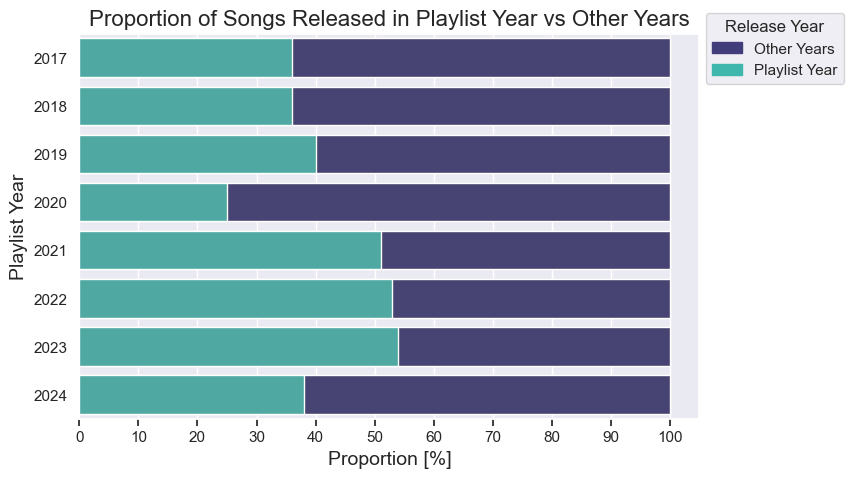

In [475]:
# Count total and same_year_release values and transform them into percantages 
total = df_playlists.groupby('year')['same_year'].count().reset_index()
same_year = df_playlists[df_playlists['same_year']==True].groupby('year')['same_year'].count().reset_index()
total['same_year'] = [i/j * 100 for i,j in zip(total['same_year'], total['same_year'])]
same_year['same_year'] = [i/j * 100 for i,j in zip(same_year['same_year'], total['same_year'])]

plt.figure(figsize=(8,5))
# Bar chart 1 - total bar
sns.barplot(data=total, x='same_year', y='year', orient='h', color=colors[1])

# Bar chart 2 - released in the same year bar (same_year = True)
sns.barplot(data=same_year, x='same_year', y='year', orient='h', color=colors[4])

plt.xlabel('Proportion [%]', size=14)
plt.ylabel('Playlist Year', size=14)
plt.title('Proportion of Songs Released in Playlist Year vs Other Years', size=16)

plt.xticks(np.arange(0, 101, 10))
plt.tick_params(axis='both', which='both', direction='out', length=5, bottom=True)  # Add tick indicators

# Add legend
total_bar = mpatches.Patch(color=colors[1], label='Other Years')
same_year_bar = mpatches.Patch(color=colors[4], label='Playlist Year')
plt.legend(title='Release Year', handles=[total_bar, same_year_bar], loc=(1.01, 0.87))


## <span style="color: #6495ED"> Q6. For the songs that were released in the playlist year, how many songs from each month ended up in the playlist? </span>

In [555]:
# Select only the songs released in the same year as the playlist year
df_same_year_release = df_playlists[df_playlists['same_year']]

# Prepare a pivot table that will be transformed into heatmap (reindex columns to ensure that all months are in the pivot table - no songs for Nov & Dec)
monthly_releases_per_year = df_same_year_release.pivot_table(index='year', columns='release_month', values='track_name', aggfunc='count').reindex(columns=np.arange(1,13,1), fill_value=0)
monthly_releases_per_year 

C:\Users\michg\AppData\Local\Temp\ipykernel_16684\3836345213.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  monthly_releases_per_year = df_same_year_release.pivot_table(index='year', columns='release_month', values='track_name', aggfunc='count').reindex(columns=np.arange(1,13,1), fill_value=0)


release_month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2017,1,3,8,4,8,5,2,1,1,3,0,0
2018,2,3,3,8,9,2,2,1,2,4,0,0
2019,1,0,10,0,6,3,15,4,0,1,0,0
2020,2,2,7,3,8,0,0,2,0,1,0,0
2021,3,1,2,3,9,6,3,14,6,4,0,0
2022,0,2,5,19,13,2,4,0,3,5,0,0
2023,5,0,1,1,25,18,2,0,2,0,0,0
2024,6,1,1,16,10,0,0,2,0,2,0,0


Text(92.25, 0.5, 'Year')

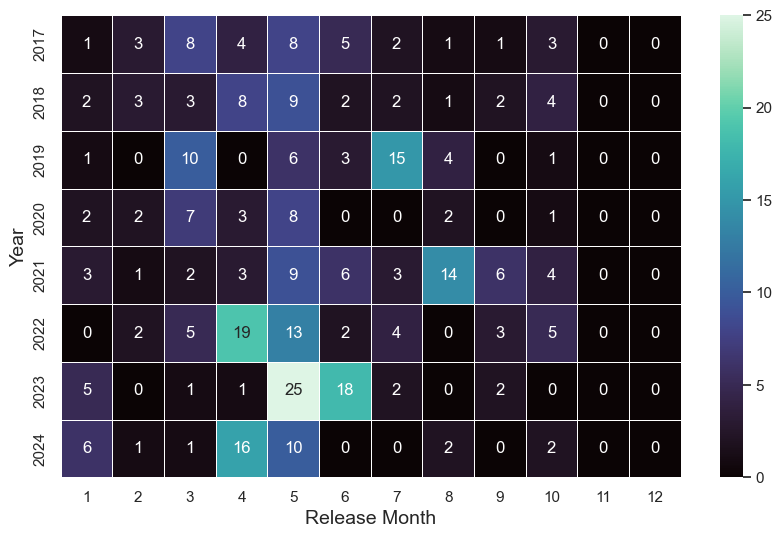

In [ ]:
# Create a heatmap 
plt.figure(figsize=(10, 6))
sns.heatmap(data=monthly_releases_per_year, cmap="mako", annot=True, linewidths=0.5)

plt.xlabel('Release Month', size=14)
plt.ylabel('Year', size=14)
plt.title('')

C:\Users\michg\AppData\Local\Temp\ipykernel_16684\2110273520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_same_year_release['release_day_of_year'] = pd.to_datetime(df_same_year_release['release_date']).dt.dayofyear


Correlation coefficient: 0.04
P-value: 0.4240


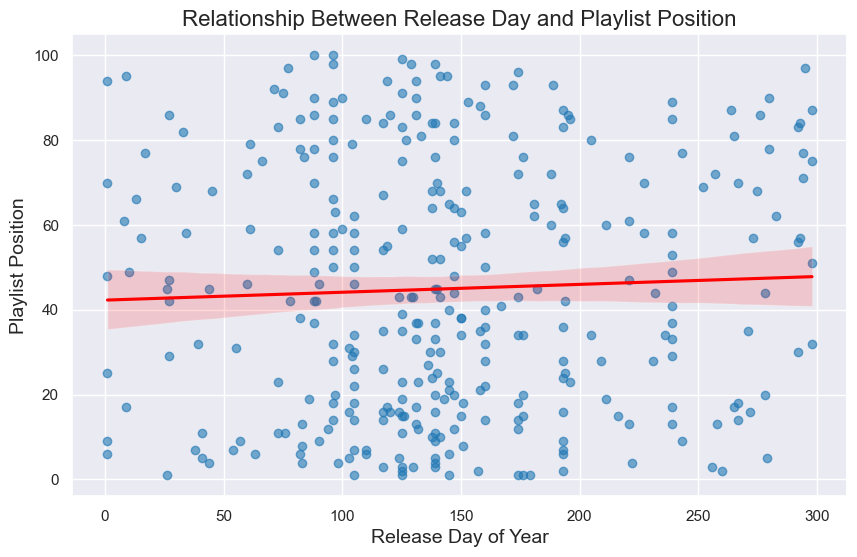

In [558]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract the day of the year (1-365) from the release date
df_same_year_release['release_day_of_year'] = pd.to_datetime(df_same_year_release['release_date']).dt.dayofyear

# Calculate the correlation coefficient
correlation, p_value = pearsonr(df_same_year_release['release_day_of_year'], df_same_year_release['position'])

print(f"Correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

# Scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_same_year_release,
    x='release_day_of_year',
    y='position',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)

plt.xlabel('Release Day of Year', size=14)
plt.ylabel('Playlist Position', size=14)
plt.title('Relationship Between Release Day and Playlist Position', size=16)
plt.show()

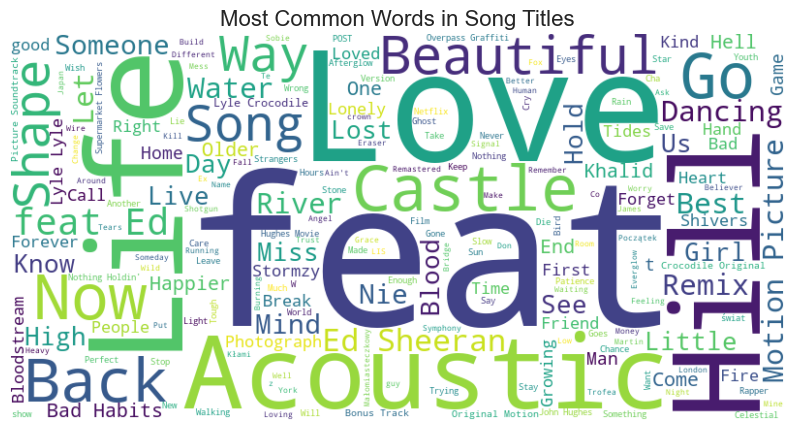

In [560]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud for song titles
text = " ".join(df_playlists['track_name'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Song Titles', size=16)
plt.show()

## Q7. Piosenki z których albumów towarzyszyły mi najbardziej na przestrzeni tych lat?
    
- countplot zbiorczy dla wszystkich lat łącznie

- countplot z podziałem na lata dla top piosenek (dla tych, które wystąpiły np. > 3 razy)

In [466]:
df_playlists['album'].value_counts().nlargest(10, keep='all')

album
- (Deluxe)                                                    29
÷ (Deluxe)                                                    21
= (Tour Edition)                                              18
=                                                             17
Divinely Uninspired To A Hellish Extent (Extended Edition)    16
You Signed Up For This                                        15
(Un)Commentary                                                15
Older                                                         14
No.6 Collaborations Project                                   14
The Pains Of Growing                                          14
Name: count, dtype: int64

# ROBOCZE

- Dla piosenek wydanych w albumach, czy jest jakaś zależność między pozycją w top playliście, a pozycją w albumie? (może niektóre pozycje są strategiczne i oznaczają nośne piosenki, które wpadają w ucho) 
- Transformacja release_date do dnia tygodnia --> w jaki dzień najczęściej były wydawane piosenki z moich topek? 
    
    - proponuję też zrobić heatmapę ReleaseDay (kalendarzowy 1-31) x ReleaseMonth 
- Boxplot/violinplot dla czasów trwania piosenki z podziałem na lata
- Proporcja nowych artystów/piosenek na przestrzeni lat --> to jakieś słupkowe wykresy albo wykres trendu liniowy?
    - innymi słowy: artyści/piosenki, które nie pojawiały się w poprzednich playlistach 
- Pie Chart for Playlist Genres
    - Purpose: Show the distribution of genres in your playlists.
-     


In [564]:
df_playlists

,year,position,track_name,artist,album,release_type,duration_ms,track_popularity,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id,release_year,release_month,release_day,same_year
0,2017,1,Walking The Wire,Imagine Dragons,Evolve,album,232906,1,11,4,2017-06-23,day,6jmngk8Fwup05JZ6kgXEGX,53XhwfbYqKCa1cC15pYq2q,5GlPAy2PRJW06GVFhKwGTl,2017,6,23,True
1,2017,2,Everglow,Coldplay,A Head Full of Dreams,album,282693,68,11,4,2015-12-04,day,5qfZRNjt2TkHEL12r3sDEU,4gzpq5DPGxSnKTe4SA8HAU,3cfAM8b8KqJRoIzt3zLKqw,2015,12,4,False
2,2017,3,Castle on the Hill - Seeb Remix,Ed Sheeran,Castle on the Hill (Seeb Remix),single,230972,34,1,1,2017-05-19,day,2SK04gQYClGFLqNGklgJpN,6eUKZXaKkcviH0Ku9w2n3V,6LhLsGjkUVzAuywuuFIkdu,2017,5,19,True
3,2017,4,The Bird's Song,MaJLo,Over The Woods,album,247225,23,10,7,2017-03-24,day,0a7e7kH7VOlwDgibIq4OpD,5aTUKcNsRYdEPhdEh7bOwL,77v43OEmXslTsE0aYCPZcc,2017,3,24,True
4,2017,5,Shape of You - Galantis Remix,Ed Sheeran,Shape of You (Galantis Remix),single,195988,39,1,1,2017-02-10,day,5H7CwzYZ60e7w69tX4ivQN,6eUKZXaKkcviH0Ku9w2n3V,6K5S3fWJ6logqsusWVaJUG,2017,2,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2024,96,Heaven,Niall Horan,The Show,album,186043,72,10,1,2023-06-09,day,5FQ77Cl1ndljtwwImdtjMy,1Hsdzj7Dlq2I7tHP7501T4,7CwQcswdSnPsSwQtskEmT4,2023,6,9,False
796,2024,97,(Isn’t It) Obvious,Alessia Cara,(Isn’t It) Obvious,single,231496,52,1,1,2024-10-21,day,2WHpyoNdtUirfIv256JznP,2wUjUUtkb5lvLKcGKsKqsR,6mDGrC2zC5bugpOTPwNedv,2024,10,21,True
797,2024,98,Movie Star,Lizzy McAlpine,Older,album,92040,46,14,4,2024-04-05,day,6aRmjhWmg9pAioffjegxtp,1GmsPCcpKgF9OhlNXjOsbS,30fIbIvd1AN04FrBt12KhM,2024,4,5,True
798,2024,99,Colourblind,Ed Sheeran,- (Deluxe),album,209267,52,18,7,2023-05-05,day,290x9rCh2EWcJ9YKpfiI9z,6eUKZXaKkcviH0Ku9w2n3V,2WFFcvzM0CgLaSq4MSkyZk,2023,5,5,False


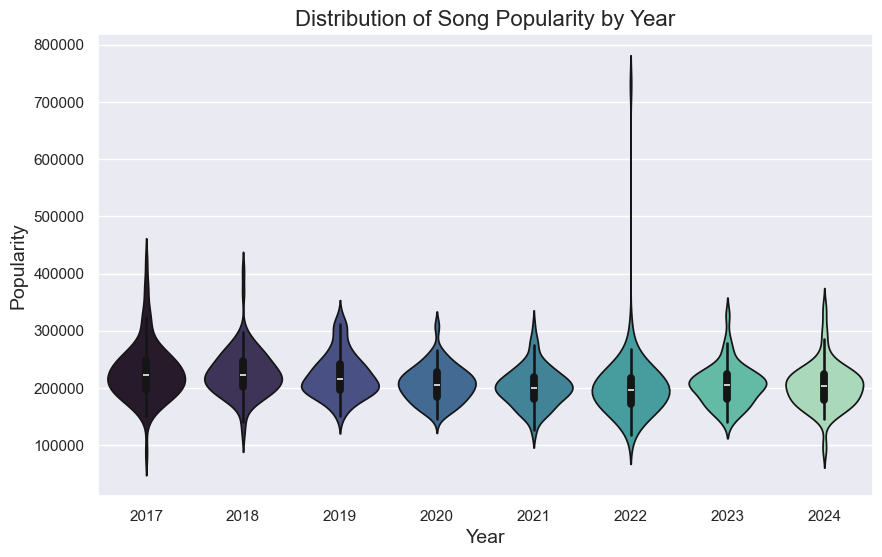

In [567]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_playlists, x='year', y='duration_ms', hue='year', palette='mako')

plt.xlabel('Year', size=14)
plt.ylabel('Popularity', size=14)
plt.title('Distribution of Song Popularity by Year', size=16)
plt.show()

Towarzyszący artyści

In [ ]:
df_playlists[df_playlists['track_name'].str.contains('feat.')]

,year,position,track_name,artist,album,release_type,duration_ms,popularity,disc_number,total_tracks,track_number,release_date,release_date_precision,track_id,artist_id,album_id
3,2022,4,Bam Bam (feat. Ed Sheeran),Camila Cabello,Familia,album,206070,59,1,12,4,2022-04-08,day,3lDSWvR0FXWGXo7mhDUs3v,4nDoRrQiYLoBzwC5BhVJzF,5Nn3fX7CuJo7tbibtqASmf
31,2022,32,Bad Habits (feat. Bring Me The Horizon),Ed Sheeran,Bad Habits (feat. Bring Me The Horizon),single,250763,58,1,1,1,2022-02-08,day,7vrKEP66NdiQDPryPG6olO,6eUKZXaKkcviH0Ku9w2n3V,6YaoDGq5SqvjU4D9oMFj2d
67,2022,68,Own It (feat. Ed Sheeran & Burna Boy),Stormzy,Heavy Is The Head,album,216706,66,1,16,11,2019-12-13,day,4QPEwDdOMhY7rNS05mTyMR,2SrSdSvpminqmStGELCSNd,3y4AaloFccKNLQcZNS9L8c
71,2022,72,For My Hand (feat. Ed Sheeran),Burna Boy,"Love, Damini",album,159123,65,1,19,13,2022-07-07,day,0HaRLPnr887lcQM2YQzkff,3wcj11K77LjEY1PkEazffa,6kgDkAupBVRSqbJPUaTJwQ
93,2022,94,Make It Out (feat. Maisie Peters),Henry Jamison,The Years,album,183360,29,1,10,7,2022-04-29,day,43to8KLXwPSvEnCgkxW7AN,2XdtmipGVPmA62ptDgX8QC,7zcCuIj4uZhrx1WfPfe9Gx
98,2022,99,See You Again (feat. Charlie Puth),Wiz Khalifa,See You Again (feat. Charlie Puth),single,229525,81,1,1,1,2015,year,2JzZzZUQj3Qff7wapcbKjc,137W8MRPWKqSmrBGDBFSop,5FXIqS1XqbpfOKNoi5VUwS
99,2022,100,Take Me Back to London (feat. Stormzy),Ed Sheeran,No.6 Collaborations Project,album,189733,61,1,15,4,2019-07-12,day,1AI7UPw3fgwAFkvAlZWhE0,6eUKZXaKkcviH0Ku9w2n3V,3oIFxDIo2fwuk4lwCmFZCx
164,2024,65,Ways To Go (feat. Khalid),Alec Benjamin,12 Notes,album,154705,33,1,13,2,2024-05-24,day,3trEwsFSTrhYlrSQdEoEgT,5IH6FPUwQTxPSXurCrcIov,56alTwsbtrn2veUwwDTdny
171,2024,72,All My Friends (feat. Tinashe & Chance the Rap...,Snakehips,All My Friends (feat. Tinashe & Chance the Rap...,single,229746,68,1,1,1,2015-10-21,day,6TaqooOXAEcijL6G1AWS2K,2FwJwEswyIUAljqgjNSHgP,5cOhR878H8hC3UsxYq5Xyv
176,2024,77,Automatic Yes (feat. John Mayer),Zedd,Telos,album,205309,52,1,10,9,2024-08-30,day,6oAwQp0fXsZObpl5PLl2GN,2qxJFvFYMEDqd7ui6kSAcq,5V7WoYwRXtheRjhOjgUeR5


BTW, spróbowałbym zrobić taki sam wykres, zaczynając od wyliczenia procentów w ten sposób   
https://stackoverflow.com/questions/64754905/create-100-stacked-bar-chart

`
df_playlists.groupby('year')['same_year'].value_counts(normalize=True)
`

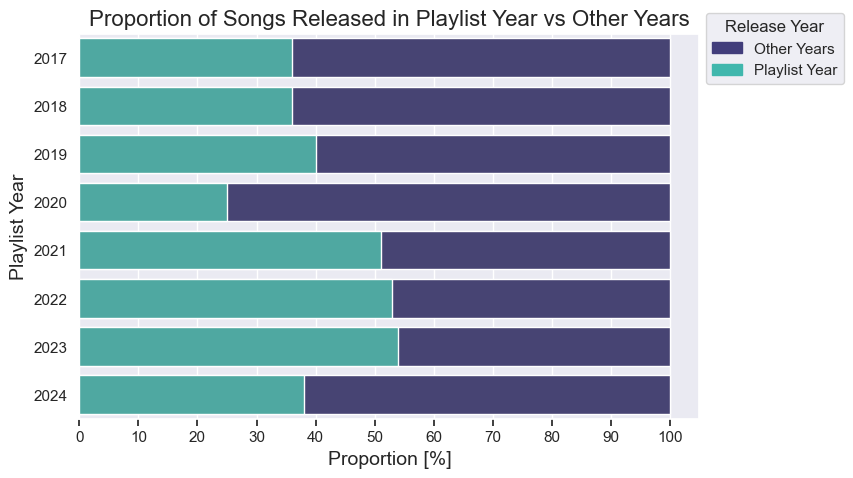

Zwróc uwagę, na dwie poniższe wersje tej samej operacji.

In [ ]:
df_playlists.groupby('artist')['track_name'].count().nlargest(10).reset_index(name='n_appearances')

,artist,n_appearances
0,Ed Sheeran,140
1,Lewis Capaldi,43
2,Alessia Cara,38
3,Alec Benjamin,36
4,Shawn Mendes,30
5,Maisie Peters,29
6,Billie Eilish,27
7,Niall Horan,24
8,Dawid Podsiadło,20
9,Lizzy McAlpine,20


In [ ]:
df_playlists['artist'].value_counts().head(10).reset_index(name='n_appearances')

,artist,n_appearances
0,Ed Sheeran,140
1,Lewis Capaldi,43
2,Alessia Cara,38
3,Alec Benjamin,36
4,Shawn Mendes,30
5,Maisie Peters,29
6,Billie Eilish,27
7,Niall Horan,24
8,Lizzy McAlpine,20
9,Dawid Podsiadło,20
